In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import matplotlib.lines as mlines

##### Read airports data

In [2]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
                        names = airport_col, index_col = 0)

In [3]:
# extract country and then extra columns
airport_us = airport_df[(airport_df.Country == "United States")][['Name','Lat', 'Long', 'IATA', 'ICAO']]

##### Read routes data

In [4]:
route_name = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = route_name)

In [5]:
# get index array of airport_us
us_airport_ix = airport_us.index.values

In [6]:
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 
routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                     (routes_df['Dest Airport ID'].isin(us_airport_ix))]

In [7]:
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))

In [8]:
# to find number of flights in and out of an airport
# it is similar to find number of rows in which each airport occur in either one of the 2 columns
counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()
# create a data frame of position based on names in count
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})
pos_data = counts.merge(airport_us, on = 'IATA')

##### Create MultiDirected Graph

In [9]:
graph = nx.from_pandas_dataframe(routes_us, source = 'Source Airport', target = 'Dest Airport',
                        edge_attr = 'counts',create_using = nx.MultiDiGraph())
nx.set_node_attributes(graph,counts, "total_ins_outs") # in 2.0, values and names' positions are switched

##### Try Basemap

In [10]:
plt.figure(figsize=(15,20))
m = Basemap(
        projection='merc',
        llcrnrlon=-180,
        llcrnrlat=10,
        urcrnrlon=-50,
        urcrnrlat=70,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

In [11]:
# import long lat as m attribute
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

In [12]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [counts['total_flight'][s]*3 for s in graph.nodes()])
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g', width = routes_us['counts']*0.75, 
                       alpha=0.2, arrows = False)

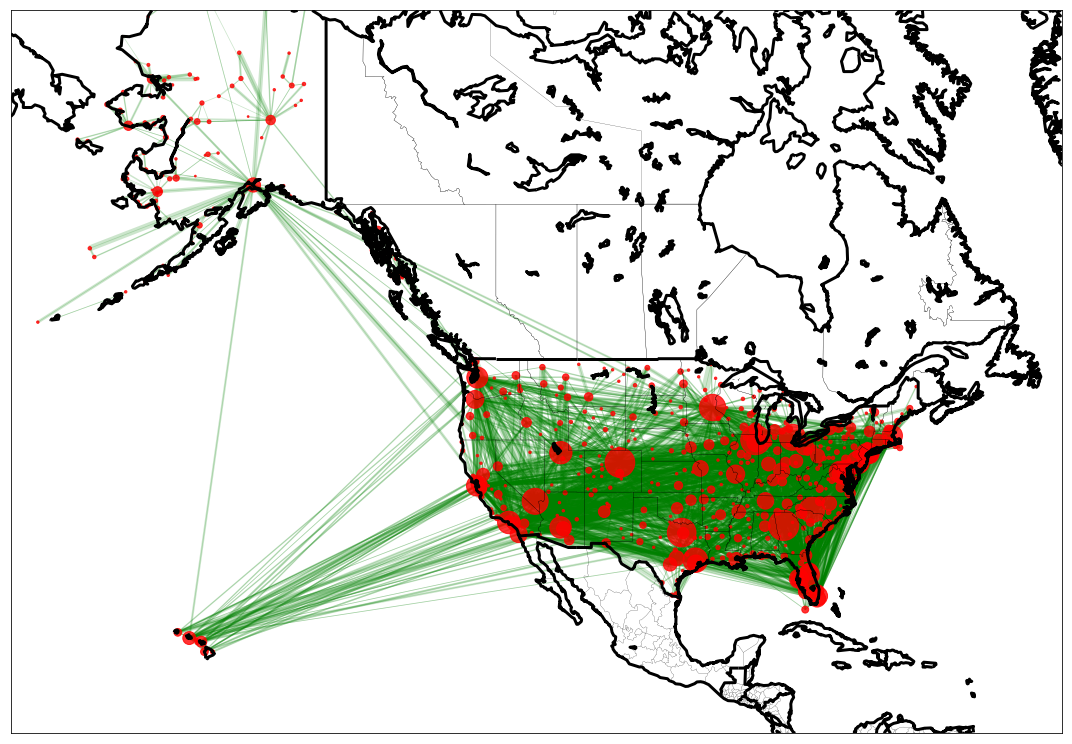

In [13]:
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
plt.tight_layout()
plt.savefig("./images/map_1.png", format = "png", dpi = 300)
plt.show()

#### In-land airports

In [14]:
### get the airport
airport_us = airport_df[(airport_df.Country == "United States") & (airport_df.Lat > 25) & (airport_df.Lat < 50) &
                       (airport_df.Long > -130) & (airport_df.Long < -60)]

In [15]:
route_name = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = route_name)
us_airport_ix = airport_us.index.values
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'].astype(str), 'coerce')
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'].astype(str), 'coerce')
routes_df = routes_df.dropna(subset=["Source Airport ID", "Dest Airport ID"]) 
routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                     (routes_df['Dest Airport ID'].isin(us_airport_ix))]
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))
routes_us.sort_values(['counts'], ascending = False).head()

,Source Airport,Dest Airport,counts
3456,ORD,ATL,20
206,ATL,ORD,19
3545,ORD,MSY,13
192,ATL,MIA,12
3052,MIA,ATL,12


In [16]:
# to find number of flights in and out of an airport
# it is similar to find number of rows in which each airport occur in either one of the 2 columns
counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()
# create a data frame of position based on names in count
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})

In [17]:
pos_data = counts.merge(airport_us, on = 'IATA')

In [18]:
#total_dic = pos_data[['IATA', 'total_flight']].set_index('IATA').T.to_dict('records')

In [19]:
graph = nx.from_pandas_dataframe(routes_us, source = 'Source Airport', target = 'Dest Airport',
                        edge_attr = 'counts',create_using = nx.MultiDiGraph())
nx.set_node_attributes(graph,counts, "total_ins_outs") # in 2.0, values and names' positions are switched

In [20]:
plt.figure(figsize=(15,20))
m = Basemap(
        projection='merc',
        llcrnrlon=-130,
        llcrnrlat=25,
        urcrnrlon=-65,
        urcrnrlat=50,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

In [21]:
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

In [22]:
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 100],
                       node_color = 'r', alpha = 0.8,
                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 100])

nx.draw_networkx_labels(G = graph, pos = pos, font_size=25,
                        labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 100})

nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 100],
                       node_color = 'b', alpha = 0.6,
                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 100])

nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g', width = routes_us['counts']*0.75, 
                       alpha=0.3, arrows = False)

D:\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


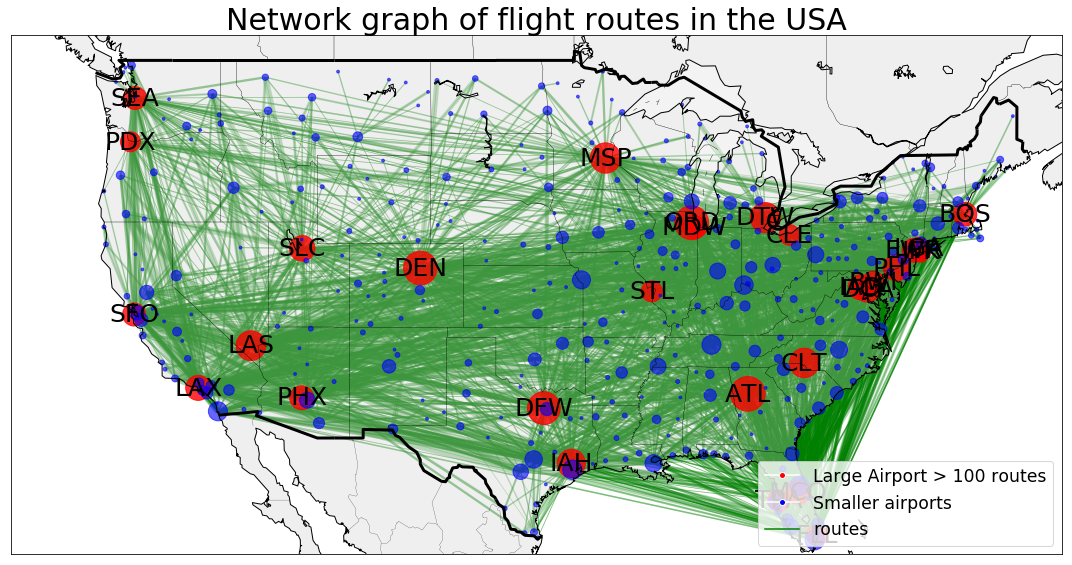

In [23]:
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
m.fillcontinents(alpha = 0.3)
line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
plt.legend((line1, line2, line3), ('Large Airport > 100 routes', 'Smaller airports', 'routes'),
           loc=4, fontsize = 'xx-large')
plt.title("Network graph of flight routes in the USA", fontsize = 30)
#m.bluemarble()
plt.tight_layout()
plt.savefig("./images/map_2.png", format = "png", dpi = 300)
plt.show()